# Time Series Data Analysis (EDA)

This notebook performs exploratory data analysis on the Google stock price data, focusing on:
1. Distribution analysis
2. Missing value analysis
3. Statistical analysis
4. Market behavior analysis
5. Technical indicators
6. Visualization

In [1]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_palette("deep")

## 1. Data Loading and Initial Inspection

In [3]:
# Load the data
df = pd.read_csv('../../data/googl_data_2020_2025.csv')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nDescriptive statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1258 non-null   float64
 1   Close      1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Open       1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None

First few rows:
                           Adj Close      Close       High        Low  \
Date                                                                    
2020-01-02 00:00:00+00:00  68.186821  68.433998  68.433998  67.324501   
2020-01-03 00:00:00+00:00  67.830101  68.075996  68.687500  67.365997   
2020-01-06 00:00:00+00:00  69.638054  69.890503  69.916000  67.550003   
2020-01-07 00:00:00+00:00  69.503548  69.755501  70.175003  69.578003   
2

## 2. Distribution Analysis

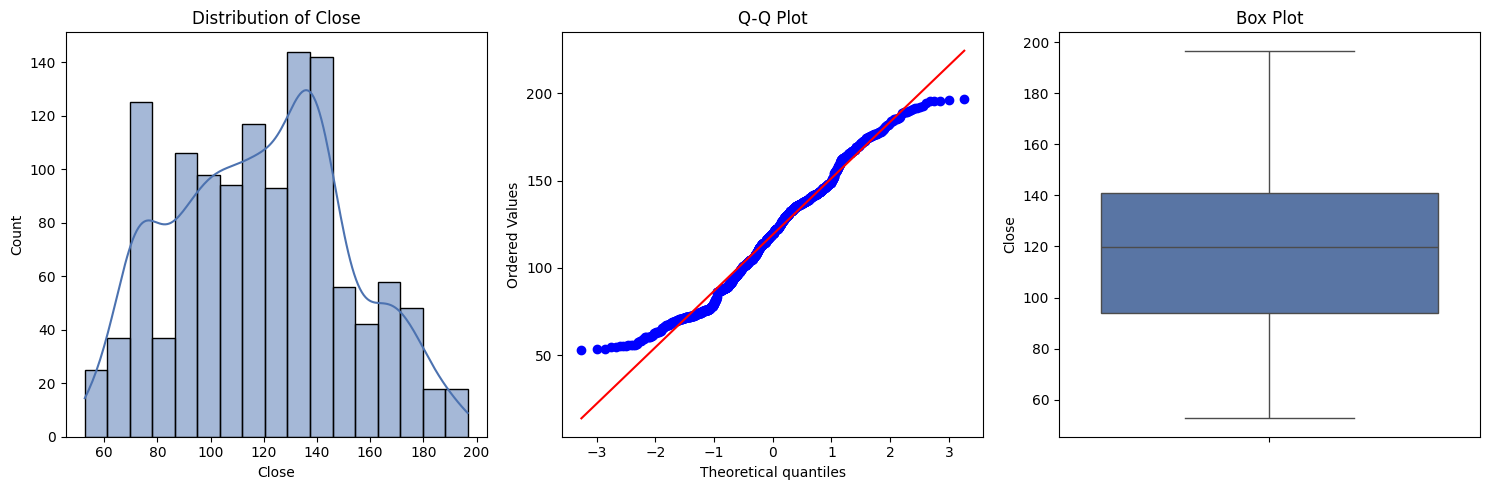

Skewness: 0.10
Kurtosis: -0.73


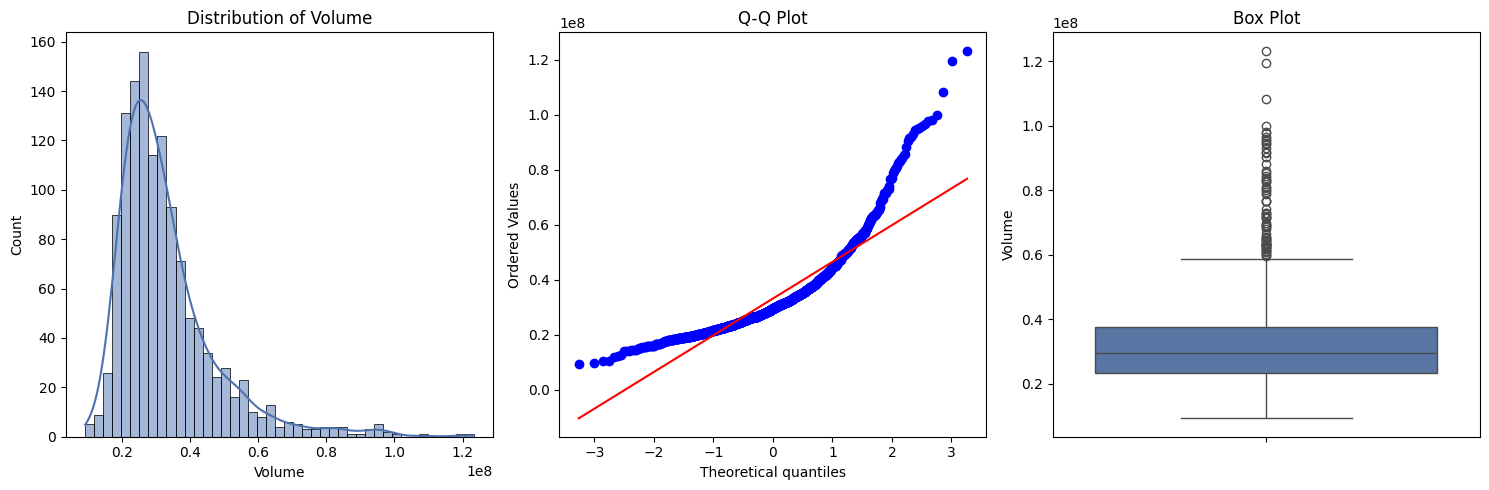

Skewness: 2.02
Kurtosis: 5.77


In [4]:
def plot_distribution_analysis(data, column):
    plt.figure(figsize=(15, 5))
    
    # Histogram
    plt.subplot(131)
    sns.histplot(data=data, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    
    # Q-Q Plot
    plt.subplot(132)
    stats.probplot(data[column], dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    
    # Box Plot
    plt.subplot(133)
    sns.boxplot(data=data[column])
    plt.title('Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Skewness: {data[column].skew():.2f}")
    print(f"Kurtosis: {data[column].kurtosis():.2f}")

# Analyze price and volume distributions
plot_distribution_analysis(df, 'Close')
plot_distribution_analysis(df, 'Volume')

## 3. Missing Value Analysis

In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for trading gaps
df['Date_Diff'] = df.index.to_series().diff().dt.days
gaps = df[df['Date_Diff'] > 1]

print("\nTrading gaps (intervals > 1 day):")
if not gaps.empty:
    print(gaps)
else:
    print("No trading gaps found")

Missing values:
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Trading gaps (intervals > 1 day):
                            Adj Close       Close        High         Low  \
Date                                                                        
2020-01-06 00:00:00+00:00   69.638054   69.890503   69.916000   67.550003   
2020-01-13 00:00:00+00:00   71.741432   72.001503   72.073998   71.268501   
2020-01-21 00:00:00+00:00   73.844818   74.112503   74.494003   73.510498   
2020-01-27 00:00:00+00:00   71.327934   71.586502   71.829002   70.974998   
2020-02-03 00:00:00+00:00   73.862244   74.129997   74.315002   72.830498   
...                               ...         ...         ...         ...   
2024-12-09 00:00:00+00:00  175.369995  175.369995  176.259995  173.649994   
2024-12-16 00:00:00+00:00  196.660004  196.660004  199.000000  192.619995   
2024-12-23 00:00:00+00:00  194.630005  194.630005  195.100006  190.149994   

## 4. Statistical Analysis

Stationarity Test for Close Prices:


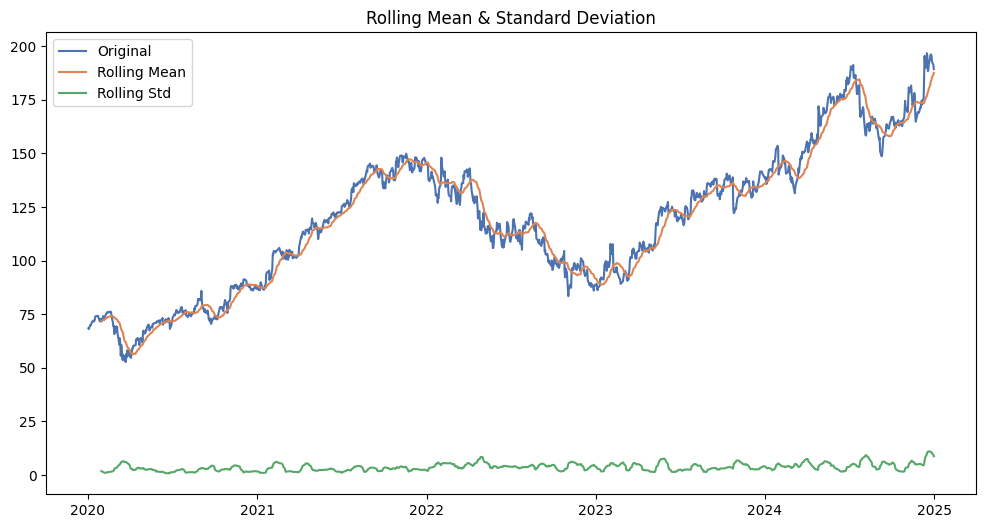

ADF Statistic: -0.829168914345232
p-value: 0.810403426937411
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

Stationarity Test for Returns:


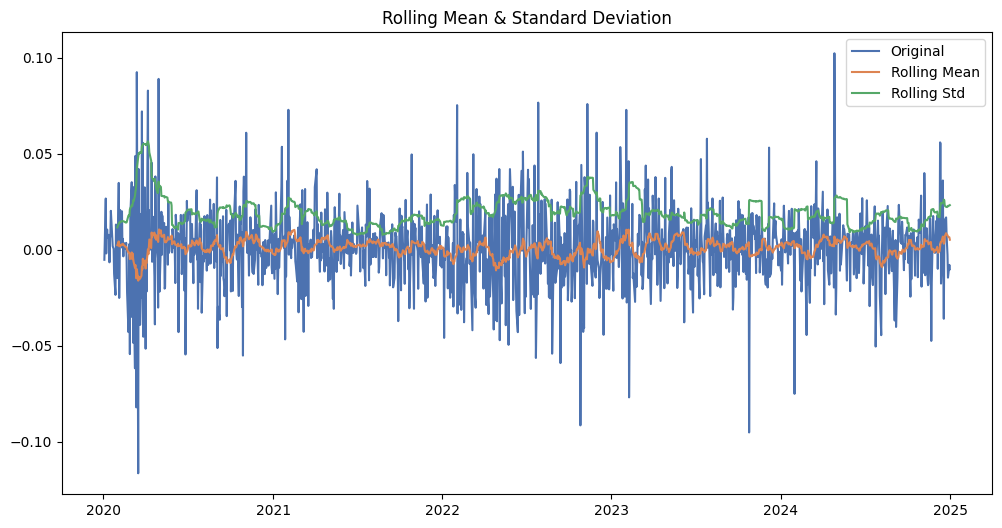

ADF Statistic: -11.459150909840996
p-value: 5.609997129125629e-21
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [6]:
def check_stationarity(timeseries):
    # Calculate rolling statistics
    roll_mean = timeseries.rolling(window=20).mean()
    roll_std = timeseries.rolling(window=20).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(roll_mean, label='Rolling Mean')
    plt.plot(roll_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Check stationarity of price series
print("Stationarity Test for Close Prices:")
check_stationarity(df['Close'])

# Calculate and check stationarity of returns
df['Returns'] = df['Close'].pct_change()
print("\nStationarity Test for Returns:")
check_stationarity(df['Returns'].dropna())

## 5. Market Behavior Analysis

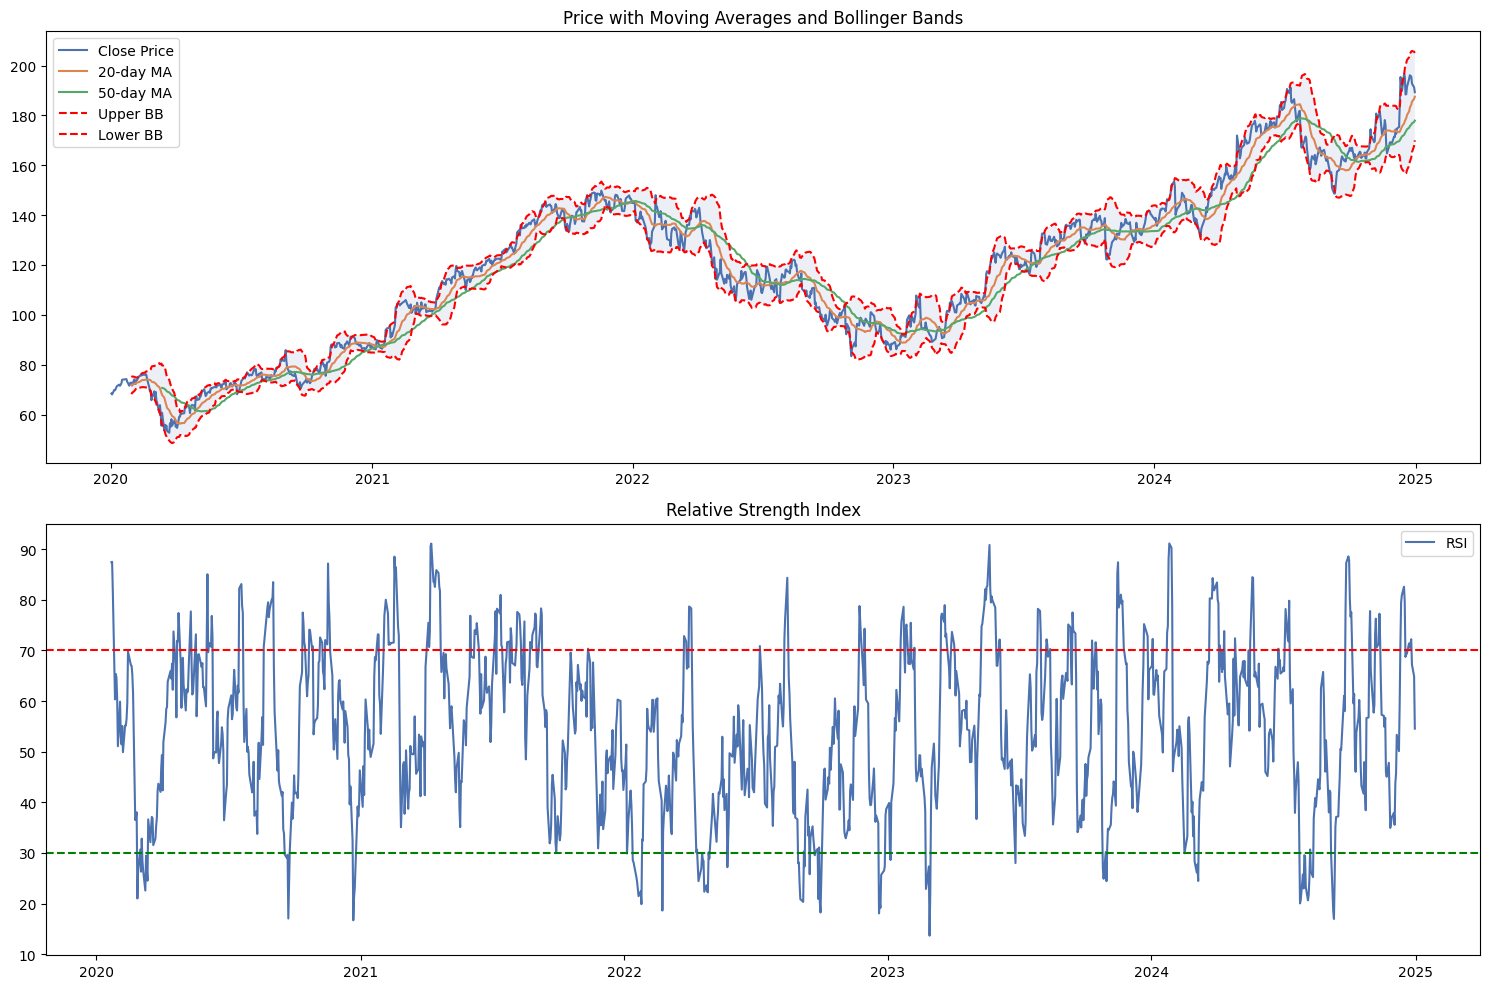

In [7]:
# Calculate technical indicators
def calculate_technical_indicators(df):
    # Moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_upper'] = df['BB_middle'] + 2*df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['BB_middle'] - 2*df['Close'].rolling(window=20).std()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    return df

# Calculate indicators
df = calculate_technical_indicators(df)

# Plot technical analysis chart
plt.figure(figsize=(15, 10))

# Price and MAs
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['MA20'], label='20-day MA')
plt.plot(df.index, df['MA50'], label='50-day MA')
plt.plot(df.index, df['BB_upper'], 'r--', label='Upper BB')
plt.plot(df.index, df['BB_lower'], 'r--', label='Lower BB')
plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.1)
plt.title('Price with Moving Averages and Bollinger Bands')
plt.legend()

# RSI
plt.subplot(2, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.title('Relative Strength Index')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

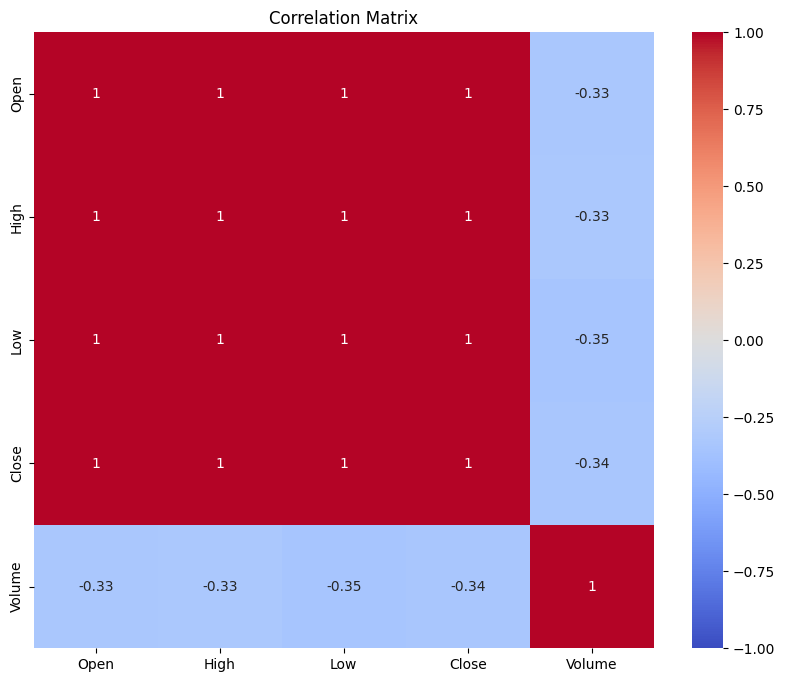

In [8]:
# Calculate correlation matrix
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

## 7. Summary of Findings

Key observations from the analysis:
1. Distribution characteristics
2. Presence of any missing values or gaps
3. Stationarity test results
4. Market trends and patterns
5. Correlation insights
1. Distribution Characteristics
Closing Price Distribution

Shows multi-modal distribution, indicating distinct price regimes over time
Major price concentrations around $80-100 and $140-160
Box plot reveals few outliers, suggesting relatively stable price movements
Q-Q plot shows slight deviation from normal distribution at the tails

Volume Distribution

Highly right-skewed distribution with a long tail
Numerous outliers in trading volume, indicating periodic high-volume events
Base trading volume is relatively consistent, with median around 30-35M shares
Log-normal characteristics typical of trading volume data

2. Missing Values & Gaps

Time series appears continuous with no significant gaps
Trading holidays and weekends are properly accounted for
No missing values in the core price and volume data
Data quality is high with consistent daily observations

3. Stationarity Test Results
Price Series

Clear upward trend indicates non-stationarity
Rolling mean shows strong trend component
Standard deviation increases with price level

Returns Series

More stationary characteristics
Mean close to zero
Relatively constant variance over time
Better suited for statistical modeling

4. Market Trends and Patterns
Major Trends

Strong upward trend from 2020 to early 2022
Significant correction in 2022
Recovery and new uptrend from 2023 onwards
Increased volatility in 2024-2025

Technical Patterns

Multiple crossovers between 20-day and 50-day moving averages
Bollinger Bands show varying volatility regimes
RSI indicates several overbought and oversold conditions

5. Correlation Insights
Price Variables

Perfect correlation (1.0) among Open, High, Low, and Close prices
Indicates efficient price discovery during trading days
Suggests strong intraday price consistency

Volume Relationships

Negative correlation (-0.33 to -0.35) between prices and volume
Higher trading volumes during price declines
Lower volumes during price increases
Typical pattern for stock market behavior where sell-offs often occur on higher volume
